# Семинар по визуализации, генерации признаков и общему плану решения практических задач

В этом практическом семинаре мы посмотрим на пример работы с набором от данных от первого взгляда на данные до построения модели. В ходе семинара обсудим важные шаги решения практической задачи: визуализируем и проанализируем данные, придумаем новые признаки на основе имеющихся, посмотрим, как строится базовое решение на основе xgboost и как подбираются гиперпараметры, как происходит отбор признаков.

За основу семинара взят [ноутбук с Kaggle Kernels](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367/notebook), автор [@beluga](https://www.kaggle.com/gaborfodor). 

В ноутбуке решается задача [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration), в которой по данным поездки на такси в Нью-Йорке необходимо предсказать продолжительность поездки. Метрика:  Root Mean Squared Logarithmic Error. Для загрузки полных данных воспользуйтесь ссылкой на соревнование. Для семинара используется сокращенная версия данных с целью сократить время вычислений.

Цитата автора ноутбука:

My best single model with these features reached LB 0.371. Linear combination of several models gave LB 0.368. Stacking added marginal improvement to 0.367.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
#import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

# Загрузка и простой анализ данных

In [2]:
np.random.seed(1987)
# для загрузки полных данных:
#train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')
# для семинара используем часть датасета (чтобы ускорить вычисления)
train = pd.read_csv("https://github.com/nadiinchi/iad2020/raw/master/materials/train_sem_features.csv")
test = pd.read_csv("https://github.com/nadiinchi/iad2020/raw/master/materials/test_sem_features.csv")

Согласно описанию данных, у нас есть следующие признаки:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - duration of the trip in seconds

Конечно же, признаки dropoff_datetime and trip_duration доступны только для обучающей выборки.

Начинаем со стандартных шагов: смотрим фрагмент данных, статистики признаков, гистограммы признаков.

Смотрим фрагмент данных:

In [4]:
print('We have {} training rows and {} test rows.'.format(train.shape[0], test.shape[0]))
print('We have {} training columns and {} test columns.'.format(train.shape[1], test.shape[1]))
train.head(2)

We have 1458644 training rows and 625134 test rows.
We have 11 training columns and 9 test columns.


id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663

Все столбцы загрузились правильно, есть признаки времени, геолокации, категориальные (нужно перекодировать), ID (нужно проанализировать его внимательнее.)

Смотрим статистики данных:

In [4]:
train.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  100000.000000    100000.000000     100000.000000    100000.000000   
mean        1.534420         1.673130        -73.973331        40.750864   
std         0.498816         1.324652          0.038868         0.028384   
min         1.000000         0.000000        -74.444595        40.495895   
25%         1.000000         1.000000        -73.991905        40.737301   
50%         2.000000         1.000000        -73.981796        40.754017   
75%         2.000000         2.000000        -73.967308        40.768333   
max         2.000000         6.000000        -72.926605        41.297848   

       dropoff_longitude  dropoff_latitude  trip_duration  
count      100000.000000     100000.000000  100000.000000  
mean          -73.973451         40.751623     951.661010  
std             0.036248          0.032454    3180.098798  
min           -74.524940         40.467426       1.000000  
25%           -73.991402         40.735790     398.000000  
50%           -73.979820         40.754335     661.000000  
75%           -73.963150         40.769581    1075.000000  
max           -72.926605         41.297840   86378.000000

Странных значений не видно, все везде логично (например, максимум 6 пассажиров, логичные минимумы/максимумы координат).

Строим гистограммы признаков:

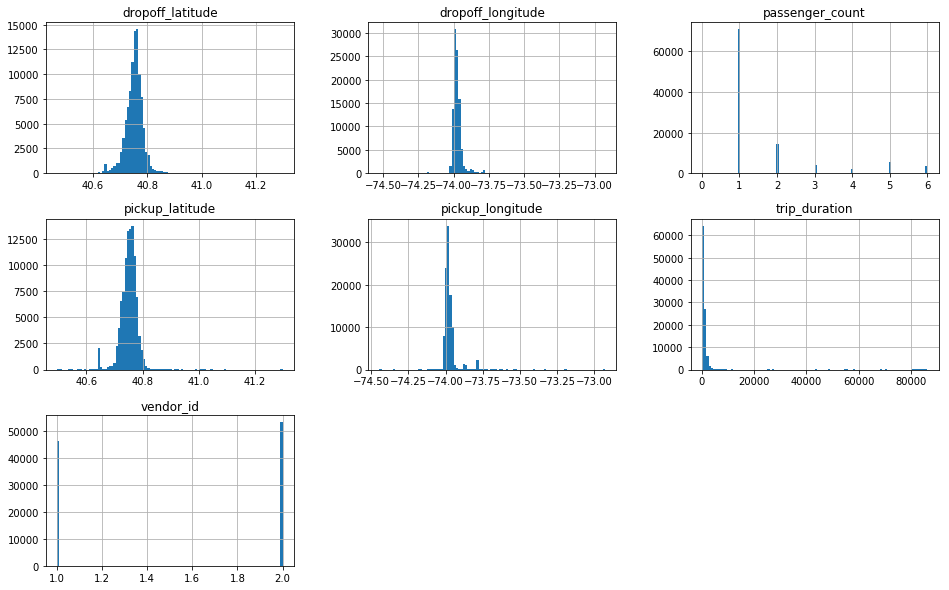

In [6]:
_ = train.hist(bins=100)

Vendor_id принимает два значения, бывают очень популярные значения в latitude и longitude (отдельные признаки для этих значений?), целевая переменная сильно перекошена (поэтому в метрике ее логарифмируют).

Сравним распределение в трейн и в тесте:

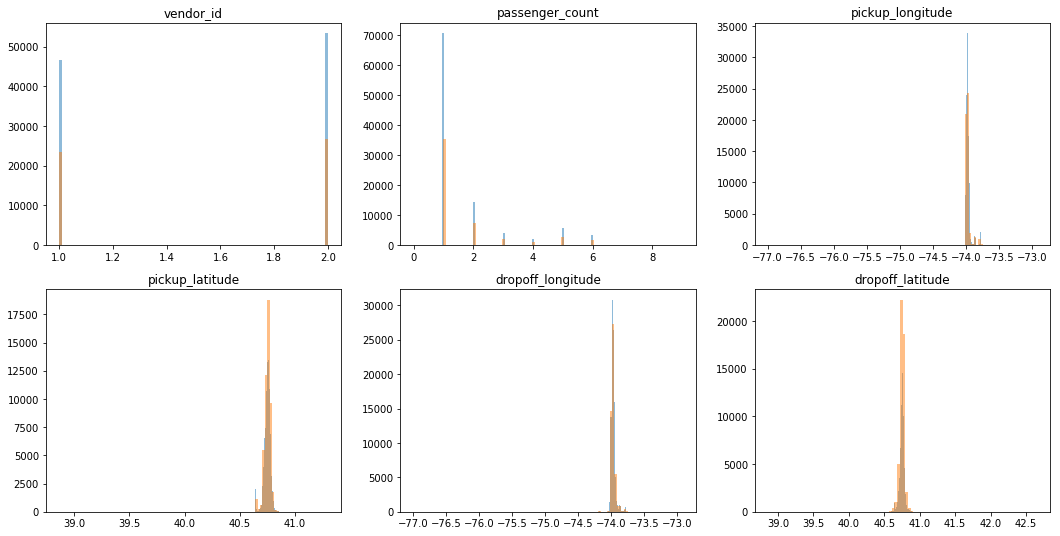

In [23]:
import seaborn
plt.figure(figsize=(18, 9))
i = 0
for feature in train.describe().columns:
    if feature in test:
        plt.subplot(2, 3, i+1)
        plt.hist(train[feature].dropna(), bins=100, alpha=0.5, label="Train")
        plt.hist(test[feature].dropna(), bins=100, alpha=0.5, label="Test")
        plt.title(feature)
        i += 1
fig.tight_layout()

Распределение данных в трейне и тесте выглядит одинаковым.

Остался не проанализированным признак с текстовым значением (на самом деле, он категориальный) - store_and_fwd_flag. Посмотрми его value_counts.

In [7]:
train["store_and_fwd_flag"].value_counts()

N    99438
Y      562
Name: store_and_fwd_flag, dtype: int64

Вторая категория редкая, но 500 объектов это не так мало - оставим признак.

Проанализируем id строк в обучении и контроле:

In [69]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('oops')
print('Train and test sets are distinct.') if len(np.intersect1d(train.id.values, test.id.values))== 0 else print('oops')
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] else print('oops')
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))

Id is unique.
Train and test sets are distinct.
We do not need to worry about missing values.
The store_and_fwd_flag has only two values {'Y', 'N'}.


Простейшая обработка данных: конвертируем признаки времени в datetime, бинаризуем признак, принимающий два значения:

In [73]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')

__Задание.__ Конвертируйте признак времени высадки пассажира в datetime:

In [74]:
# student's code here
train['dropoff_datetime'] = 

Проверяем признак длины поездки в обучении:

In [75]:
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


Максимальная длительность поездки:

In [13]:
# эта ячейка посчитана по полным данным, ее лучше не перезапускать :)
# ячейка выдает число 979
train['trip_duration'].max() // 3600

979

Максимальная длина поездки около 1000 часов. Видимо, поэтому выбрана метрика RMSLE (MSE для логарифма целевой переменной). Логарифмируем целевую переменную, чтобы далее работать только с ней:

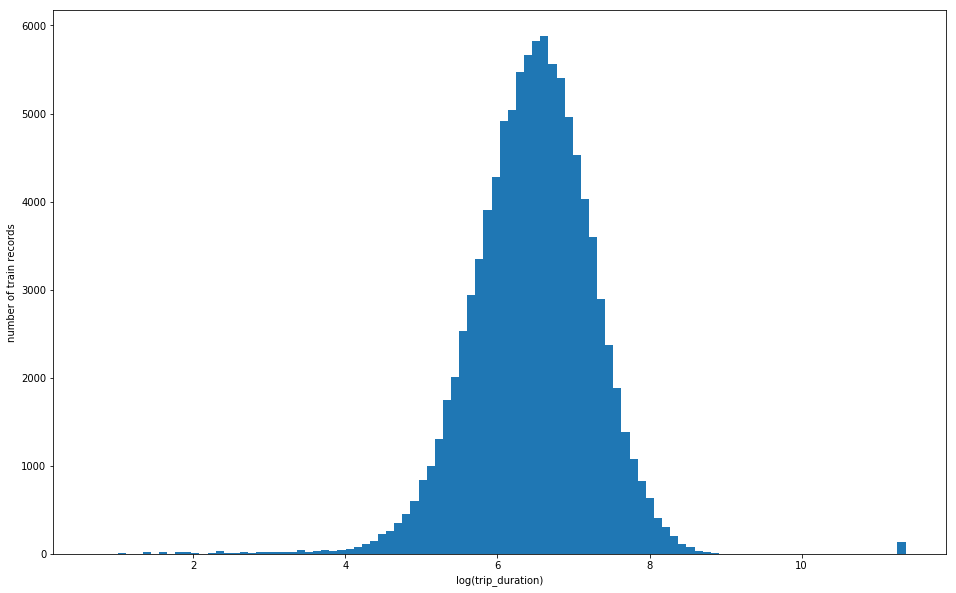

In [76]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

## Выбор стратегии валидации

Проверяем разделение на обучение и контроль. Это даст нам больше понимания, как учтраивать локальную валидацию модели, и поможет правильно выбрать, какие добавить признаки.

Какие дни присутствуют в обучении и контроле?

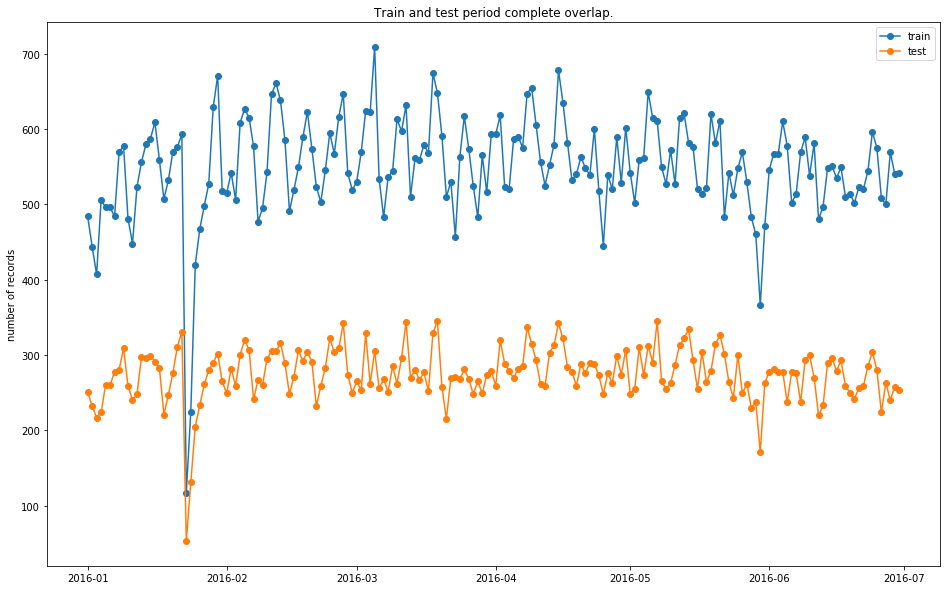

In [57]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

Какие координаты присутствуют в обучении и контроле?

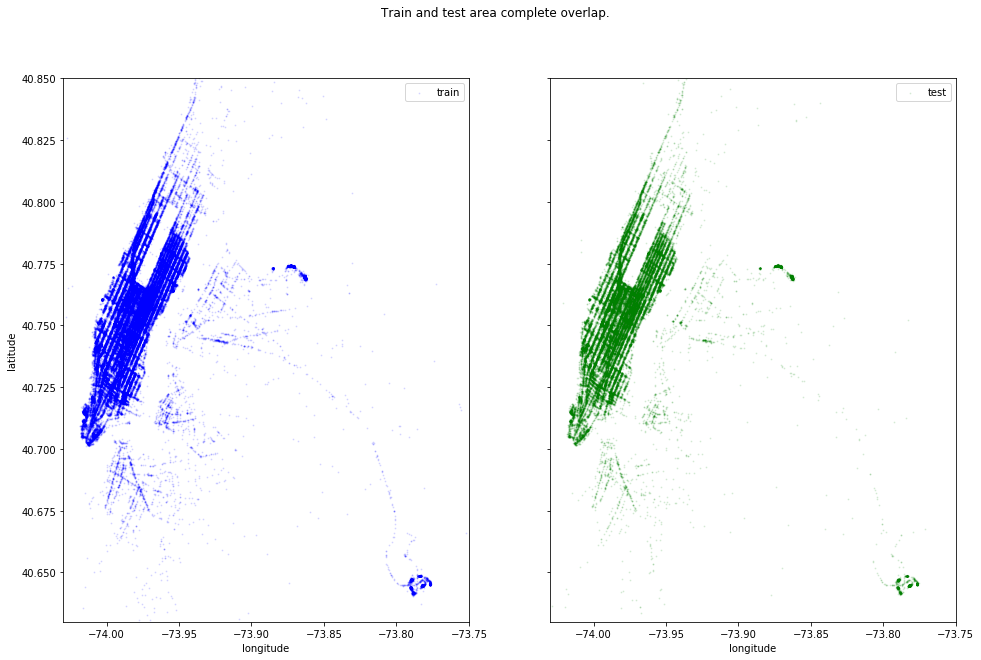

In [58]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:N], \
              train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:N], \
              test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

Разделение на обучение и контроль случайное. Это позволяет не переживать насчет выделения локальных обучающей и контрольной выборок по времени или по координатам.

# Feature Extraction / Генерация новых признаков

## Признаки расстояния. PCA
Используем PCA для транформации широты и долготы. По утверждению автора ноутбука, поворот должен помочь найти лучшие разбиения в дереве. Уменьшение рамерности мы здесь не делаем.

Примените PCA (уже импортирован). Следуйте инструкциям в ячейке.

In [79]:
ar1 = train[['pickup_latitude', 'pickup_longitude']].values
ar2 = train[['dropoff_latitude', 'dropoff_longitude']].values
ar3 = test[['pickup_latitude', 'pickup_longitude']].values
ar4 = test[['dropoff_latitude', 'dropoff_longitude']].values

# Соедините все четыре массива в один по вертикали (по "объектам")
coords = 

# Создайте объект PCA
pca = 

# Обучите PCA на координатах


# Применяем pca (вызываем transform и берем нулевой или первый столбец)
train['pickup_pca0'] = pca.transform(ar1)[:, 0]
train['pickup_pca1'] = pca.transform(ar1)[:, 1]
train['dropoff_pca0'] = pca.transform(ar2)[:, 0]
train['dropoff_pca1'] = pca.transform(ar2)[:, 1]
test['pickup_pca0'] = pca.transform(ar3)[:, 0]
test['pickup_pca1'] = pca.transform(ar3)[:, 1]
test['dropoff_pca0'] = pca.transform(ar4)[:, 0]
test['dropoff_pca1'] = pca.transform(ar4)[:, 1]

Для примера посмотрим, что получилось после трансформации PCA:

In [80]:
pca.transform(ar1)

array([[ 0.01875249, -0.00478313],
       [ 0.01728857, -0.03163238],
       [-0.03830517,  0.05120896],
       ...,
       [ 0.04541945, -0.03641789],
       [ 0.01534527, -0.001285  ],
       [ 0.03461587, -0.04168955]])

Визуализируем выполненную трансформацию с помощью PCA:

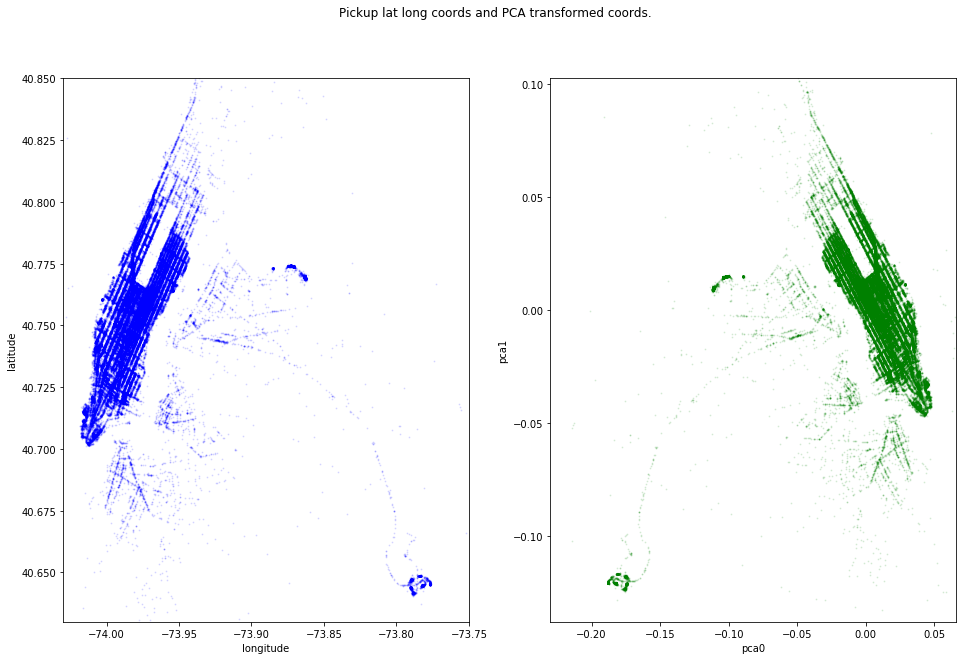

In [81]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

## Признаки расстояния

Вычислим расстояния между местом посадки и высадки. Ниже используются сложные функции расстояния, не стоит сильно вникать в их код.  К примеру, используется расстояние на сфере - [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula). Кроме того, код вычисляет среднюю точку маршрута как дополнительный признак.

Цитата автора ноубука:

The cabs are not flying and we are in New York so we could check the Manhattan (L1) distance too :) 

In [82]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train['distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train['distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train['direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train['pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test['distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test['distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test['direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test['pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train['center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train['center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test['center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test['center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

Вычислите манхэттанское расстояние (модуль разности широт плюс модуль разности долгот):

In [84]:
# student's code here
train["distance_manhattan"] = 
test["distance_manhattan"] = 

## Признаки времени

Посчитаем простые функции по времени: выделим день недели, час, время, сравним дни и часы высадки и посадки:

In [78]:
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

## Скорость
Скорость - простой производный признак от двух предыдущих.

Вычислите скорость для трех функиц расстояния. Напоминание: скорость = расстояние делить на время. Вам понадобятя следующие признаки: distance_haversine, distance_dummy_manhattan, distance_manhattan, trip_duration.

In [86]:
# student's code
train.loc[:, 'avg_speed_h'] = 
train.loc[:, 'avg_speed_dm'] = 
train.loc[:, 'avg_speed_m'] = 

Посмотрим на скорость как на функцию по времени:

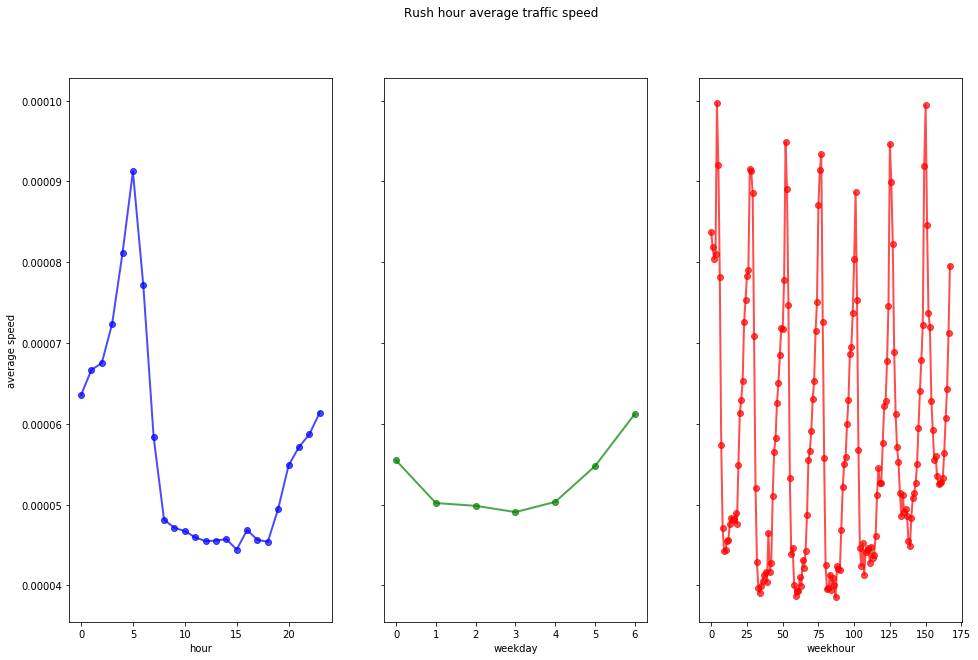

In [87]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_m'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_m'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_m'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

Все зависимости логичны.

Посмотрим на скорость как на функцию от геопозиции:

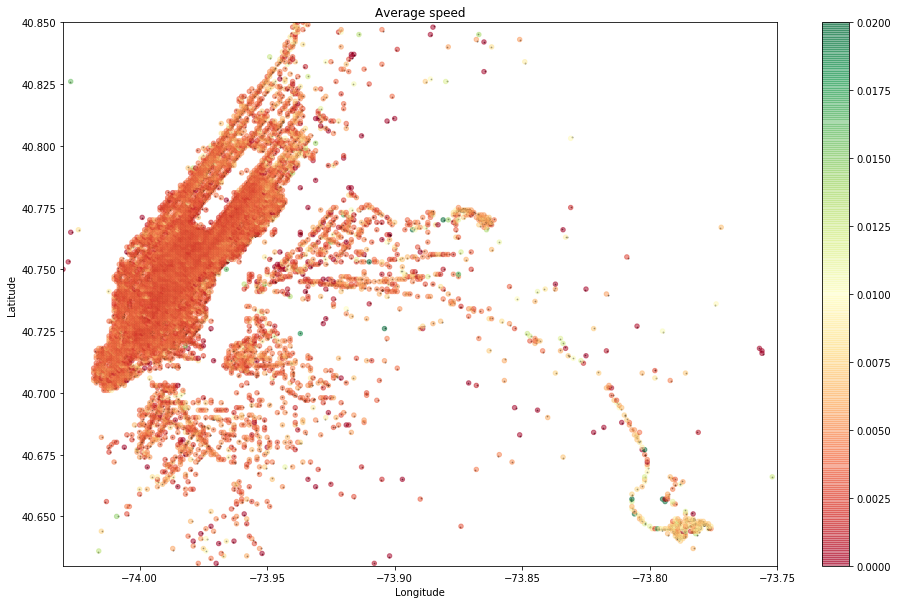

In [65]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
#coord_stats = coord_stats[coord_stats['id'] > 100]
plt.scatter(train.pickup_longitude.values, train.pickup_latitude.values,
           color='black', s=1, alpha=0.5)
plt.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
           c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=0, vmax=0.02)
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Average speed')
plt.colorbar()
plt.show()

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

Ожидаемо, что где-то очень далеко скорость меньше, чем в центре :)

# На следующем семинаре

* Кластеризация геопозиций и признаки на основе кластеризации
* Обучение xgboost и подбор гиперпараметров
* Отбор признаков